# Axial turbomachine design

### turbomachinery: **axial compressor**
### target:
- $\beta = \frac{P_{t1}}{P_{t0}} = 1.45$

- max efficiency 
### constraints:
- $\dot{m} = 100 \frac{kg}{s}$
- $\phi_{tip}|_{max} = 0.9 m$
### compressor inlet conditions:
- $P_{T0} = 1 bar$
- $T_{T0} = 300 K$

In [78]:
# importing libraries 
import numpy as np 
from thermoTransf.thermoProcess import *
from turboCoeff import similarity
from turboCoeff import coeff

# data
# constraints
mFlux = 100     # mass flux                [kg/s]
betaP = 1.45    # compression ratio        [--]
maxD  = 0.9     # maximum tip diameter     [m]
maxR  = maxD/2  # maximum tip radius       [m]

# inlet values
Pt0 = 1e+5      # inlet total pressure     [Pa]
Tt0 = 300       # inlet total temperature  [K]

### Air properties, data from **charts** & other **design assumptions**

Air properties:
- air properties **do not change** in the stage

Data from charts:
- $\beta$ allows using a single stage axial compressor 
    - it is worth noting we are close to the **efficiency limit** for an axial compressor stage ($max \approx 1.6$)
- **ASME** initial design procedure:
    - **assumption**:
        - $\alpha < 70^{\circ}$
        - working condition far enough from **surge** conditions 
            - **surge** conditions expressed as the $\phi \text{ such that } \psi \approx 1$
        - W. $\frac{\boldsymbol{W}_2}{\boldsymbol{W}_1} < 0.7$
    - from these assumptions:
        - $\psi$
            1. build **chart**
            1. chose a proper value of $\phi$
            1. compute $\psi$
        - $\eta$
            1. build **chart** 
            1. chose a proper value of $\chi$
            1. use the previous $\phi$
            1. compute $\eta$
Other design assumptions:
- $V_{t0} \approx 0 \frac{m}{s}$, so mainly only axial flow speed $V_0$
- $r_{mean} \approx 0.7 m$
- it is assumed that the revolution velocity at the midspan of the blade is equal at the inlet and at the outlet: $U_0|_{midspan} = U_1|_{midspan} = U_2|_{midspan} = U_{mean}$    
    - the blade midspan keeps always the same radius
- the stator inlet quantities are equal to the rotor outlet quantities

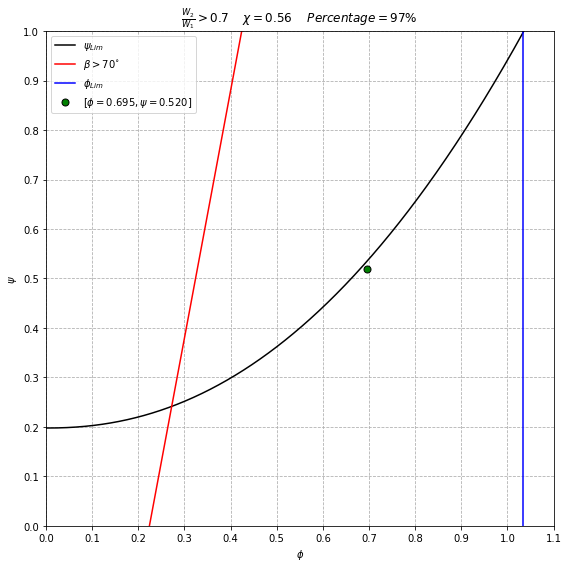

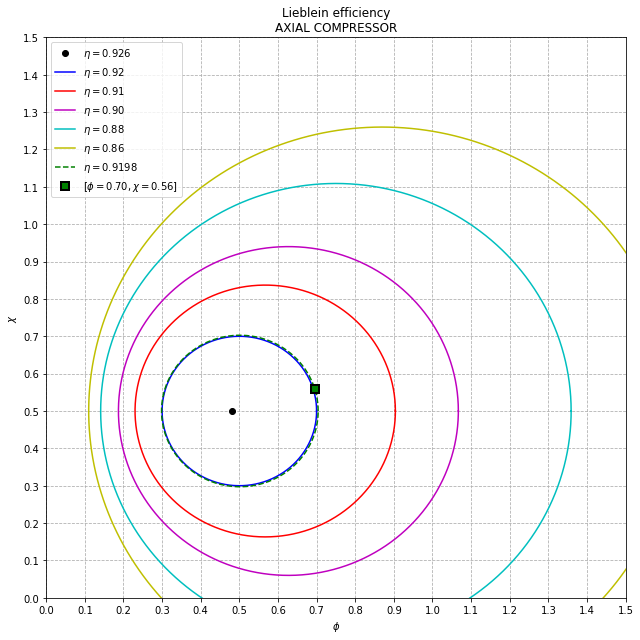

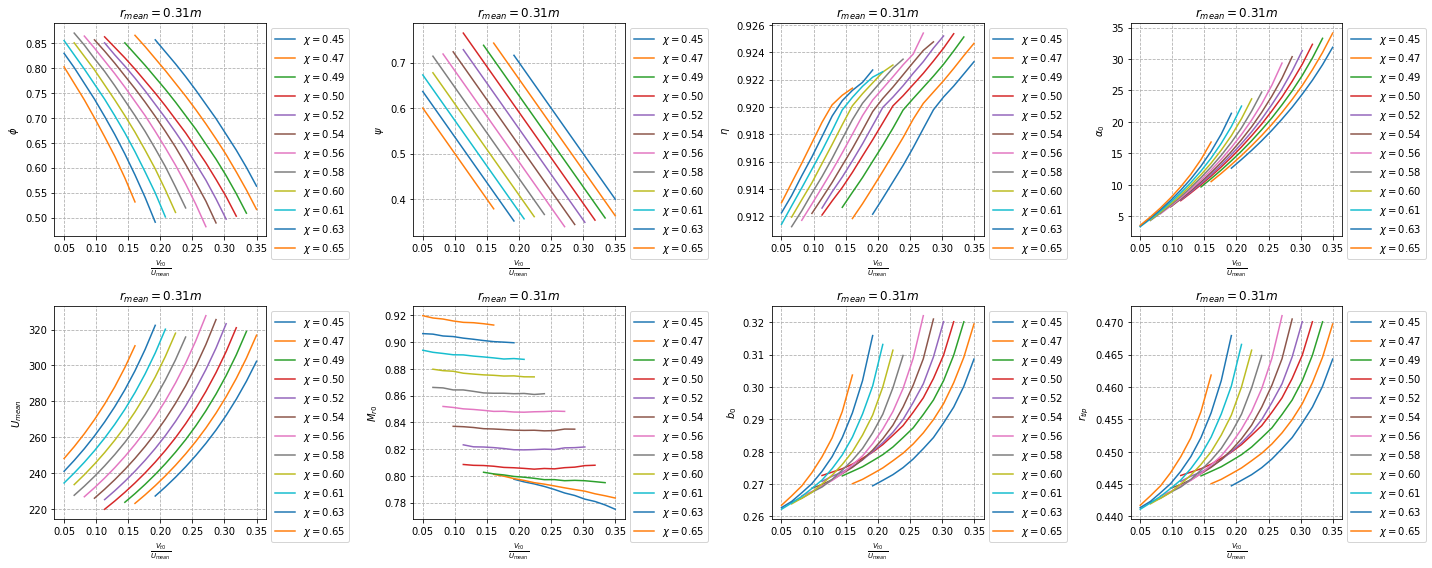

In [79]:
# air properties allocation 
R     = 287.06                  # air gas constant Ru / Mm      [J/kg K]
gamma = 1.4                     # specific heat ratio           [--]
cP    = gamma / (gamma - 1) * R # specific heat ratio @ P cost  [J/kg K]
cV    = cP - R                  # specific heat ratio @ V cost  [J/kg K]

# stage hypothesis
# reaction degree
rD = 0.56
# stage mean radius -> radius @ inlet blade midspan
rMean = 0.31  
# rotor inlet tangential velocity
Vt0Umean = 0.18

# Vt0 = (1 - rD - lam/4) * Umean -> lam = 4 * (1 - rD - Vt0/Umean) 
# psi = lam / 2 
lam = (1 - rD - Vt0Umean) * 4 
psiTarget = lam / 2

# plotting charts 
phi, psi = similarity.stagePerf(psi=psiTarget, rD=rD, plot=True, perc=0.97)
eta = similarity.efficiency(phi=phi, rD=rD, plot=True)
similarity.stageStudy(mFlux, betaP, rMean, Pt0, Tt0)

## Rotor design

work computation: **only** the rotor works (the stator **converts** kinetic energy into enthalpy and so also pressure variation)

using:

- $L_{is} = c_p \ T_{T0} \ (\beta^{\frac{\gamma - 1}{\gamma}} - 1) = c_P \ (T_{T1is} - T_{T0})$

- $L = \frac{L_{is}}{\eta} = c_P \ (T_{T1r} - T_{T0})$

In [80]:
# ideal compression work 
Lis = coeff.L_is(Tin=Tt0, beta=betaP, gamma=gamma, kind='compressor')
# real compression work 
L = Lis / eta
# total temperature computation
Tt1 = L / cP + Tt0

rotation speed and angular speed computation

using:

- $\psi = \frac{L_{is}}{U_{mean}^2}$

- $U_{mean} = \omega \ r_{mean}$

- $\omega = \frac{2 \ \pi n}{60}$

In [81]:
# mean section revolution speed from work coefficient
Umean = np.sqrt(L / psi) 
# angular speed 
omega = Umean / rMean
# rpm 
n = omega * 60 / (2 * np.pi)

inlet velocity and temperature computation

- $\phi = \frac{V_{a0}}{U_{mean}}$

In [82]:
# axial inlet velocity from flow coefficient
Va0 = phi * Umean
# tangential inlet velocity from reaction degree and work coefficient
Vt0 = (1 - rD - lam/4) * Umean 

tangential velocity computation

- $\lambda = 2 \ \psi = 2 \ \frac{V_{t1} - V_{t0}}{U_{mean}} = \frac{4 \ (V_{t\infty} - V_{t0})}{U}$

- $V_{T1} = U_{mean} \ (1 - \chi - \frac{\lambda}{4})$

- $L_{is} = \Delta h_T = U_{mean} (V_{T1} - V_{T0})$

In [83]:
# under Umean assumption & Vt0 assumption
Vt1 = (1 - rD + lam/4) * Umean 
Vtinf = (Vt1 + Vt0)/2

inlet quantities

- $\boldsymbol{V} = \boldsymbol{W} + \boldsymbol{U}$

- $a = \sqrt{\gamma \ R \ T}$

- $P_0 = P_{t0} \ (1 + \frac{\gamma - 1}{2} M_0^2)^{\frac{\gamma}{\gamma-1}}$

- $\frac{P_0}{\rho_0} = R \ T_0$

In [84]:
# main inlet quantities computation
# kinetics 
# relative speed computation 
Wa0 = Va0
Wt0 = Vt0 - Umean
# veolcity magnitude computation
W0 = np.sqrt(Wa0**2 + Wt0**2)
V0 = np.sqrt(Va0**2 + Vt0**2)
# aerodynamic angles computation 
alpha0 = np.rad2deg(np.arctan(Vt0/Va0))
beta0 = np.rad2deg(np.arctan(Wt0/Wa0))

# thermodynamics
# static temperature computation
T0 = Tt0 - V0**2 / (2*cP)
# speed of sound computation
a0 = np.sqrt(gamma * R * T0)
# mach computation 
M0 = V0 / a0
Mr0 = W0 / a0
# static pressure computation
P0 = Pt0 / (1 + (gamma - 1)/2 * M0**2)**(gamma/(gamma-1))
# density computation 
rhot0 = Pt0 / (R * Tt0)
rho0 = rhot0 / (1 + (gamma - 1)/2 * M0**2)**(1/(gamma-1))

outlet quantities

due to ideal transformation: $\Delta s = 0$

steps: 

1. computing $V_1$ with velocity triangles and $L_{is}$
2. computing $T_1$ from $L_{is} \rightarrow T_{1is}$ and $V_1$
3. computing $P_1$ with adiabatic + isentropic transformation given: $T_0, T_1, P_0$
4. computing $P_{t1}$ as an isentropic transformation from $(T_1, P_1)$ to $(T_{t1}, P_{t1})$
5. computing $\rho_1$ from $T_1, P_1$

In [85]:
# outlet quantities 
Va1 = Va0 
Wa1 = Va1 
Wt1 = Vt1 - Umean
# velocity magnitude computation
V1 = np.sqrt(Va1**2 + Vt1**2)
W1 = np.sqrt(Wa1**2 + Wt1**2)
# flow angle computation
alpha1 = np.rad2deg(np.arctan(Vt1/Va1))
beta1 = np.rad2deg(np.arctan(Wt1/Wa1))

# thermodynamics
# static temperature computation
T1 = Tt1 - V1**2 / (2*cP)
# speed of sound computation 
a1 = np.sqrt(gamma * R * T1)
# mach number computation 
M1 = V1 / a1
Mr1 = W1 / a1
# pressure computation
P1 = P0 * (T1/T0)**(gamma/(gamma-1))
Pt1 = P1 * (Tt1/T1)**(gamma/(gamma-1))
# density computation
rhot1 = Pt1 / (R * Tt1)
rho1 = rhot1 / (1 + (gamma - 1)/2 * M1**2)**(1/(gamma-1))

## Stator design

Total quantities conserves in the isentropic case.

Since the stator is a **stationary** component $\boldsymbol{W} = \boldsymbol{0}$.

In [86]:
# main outlet quantities 
# temperature computation
Tt2 = Tt1
deltaH = (1 - rD) * L
T2 = deltaH / cP + T1 
# speed computation
Va2 = Va1
V2 = np.sqrt(2 * cP * (Tt2 - T2))
Vt2 = np.sqrt(V2**2 - Va2**2)
# relative speed computation 
# relative speed == absolute speed -- stator 
Wa2 = Va2 
Wt2 = Vt2 - 0 
W2 = np.sqrt(Wa2**2 + Wt2**2) 
# aerodynamics angles computation
alpha2 = np.rad2deg(np.arctan2(Vt2,Va2))
beta2 = np.rad2deg(np.arctan(Wt2/Wa2))
# thermodynamics
# speed of sound 
a2 = np.sqrt(gamma * R * T2)
# mach number computation 
M2 = V2 / a2
Mr2 = W2 / a2
# pressure computation
Pt2 = Pt1
P2 = P1 * (T2/T1)**(gamma/(gamma-1))
# density computation
rhot2 = Pt2 / (R * Tt2)
rho2 = rhot2 / (1 + (gamma - 1)/2 * M2**2)**(1/(gamma-1))

## Blade height
- $\dot{m} = 2 \ \pi \ r_{mean} \ b_0 \ V_{a0} \ \rho_0$
- $\dot{m} = 2 \ \pi \ r_{mean} \ b_1 \ V_{a1} \ \rho_1$
- $\dot{m} = 2 \ \pi \ r_{mean} \ b_2 \ V_{a2} \ \rho_2$

In [87]:
# rotor inlet blade height 
b0 = mFlux / (rho0 * 2 * np.pi * rMean * Va0)
# rotor outlet/stator inlet  blade height
b1 = mFlux / (rho1 * 2 * np.pi * rMean * Va1)
# stator outlet blade height
b2 = mFlux / (rho2 * 2 * np.pi * rMean * Va2)

## Velocity triangles

## print **results**

In [88]:
# print data 
printLength = 82
nAdim = int((printLength - len(' ADIMENSIONAL PARAMETERS '))/2)
print('*' * nAdim + ' ADIMENSIONAL PARAMETERS  ' + '*' * nAdim)
print('-- rD     = {0:>8.2f}        -- psi    = {1:>8.2f}        -- phi       = {2:>5.2f}'.format(cP * (T1 - T0) / L, psi, phi))
print('-- eta    = {0:>10.4f}      -- lamdba = {1:>8.2f}        -- Vt0/Umean = {2:>5.2f}'.format(eta, lam, Vt0Umean))
nWork = int((printLength - len(' WORK '))/2)
print('*' * nWork + ' WORK ' + '*' * nWork)
print('-- Lis    = {0:>8.2f} J/kg   -- L      = {1:>8.2f} J/kg   -- eta    = {2:>10.4f}'.format(Lis, L, eta))
nRotation = int((printLength - len(' ROTATION '))/2)
print('*' * nRotation + ' ROTATION ' + '*' * nRotation)
print('-- Umean  = {0:>8.2f} m/s    -- omega  = {1:>8.2f} rad/s  -- n      = {2:>8.2f} rpm'.format(Umean, omega, n))
print('*' * printLength)
nDefinitions = int((printLength - len(' DEFINITIONS '))/2)
print('\n' + '*' * nDefinitions + ' DEFINITIONS  ' + '*' * nDefinitions)
print('-- 0 => rotor inlet         -- 1 => rotor outlet        -- 2 => stator outlet')
nTotTemp = int((printLength - len(' TOTAL TEMPERATURE '))/2)
print('*' * nTotTemp + ' TOTAL TEMPERATURE  ' + '*' * nTotTemp)
print('-- Tt0    = {0:>8.2f} K      -- Tt1    = {1:>8.2f} K      -- Tt2    = {2:>8.2f} K'.format(Tt0, Tt1, Tt2))
nAbsKin = int((printLength - len('KINETICS -- ABSOLUTE '))/2)
print('*' * nAbsKin + ' KINETICS -- ABSOLUTE ' + '*' * nAbsKin)
print('-- 0                        -- 1                        -- 2')
print('-- alpha0 = {0:>8.2f} deg    -- alpha1 = {1:>8.2f} deg    -- alpha2 = {2:>8.2f} deg'.format(alpha0, alpha1, alpha2))
print('-- Va0    = {0:>8.2f} m/s    -- Va1    = {1:>8.2f} m/s    -- Va2    = {2:>8.2f} m/s'.format(Va0, Va1, Va2))
print('-- Vt0    = {0:>8.2f} m/s    -- Vt1    = {1:>8.2f} m/s    -- Vt2    = {2:>8.2f} m/s'.format(Vt0, Vt1, Vt2))
print('-- V0     = {0:>8.2f} m/s    -- V1     = {1:>8.2f} m/s    -- V2     = {2:>8.2f} m/s'.format(V0, V1, V2))
nRelKin = int((printLength - len('KINETICS -- RELATIVE '))/2)
print('*' * nRelKin + ' KINETICS -- RELATIVE ' + '*' * nRelKin)
print('-- 0                        -- 1                        -- 2')
print('-- U0     = {0:>8.2f} m/s    -- U1     = {1:>8.2f} m/s    -- U2     = {2:>8.2f} m/s'.format(Umean, Umean, 0))
print('-- beta0  = {0:>8.2f} deg    -- beta1  = {1:>8.2f} deg    -- beta2  = {2:>8.2f} deg'.format(beta0, beta1, beta2))
print('-- Wa0    = {0:>8.2f} m/s    -- Wa1    = {1:>8.2f} m/s    -- Wa2    = {2:>8.2f} m/s'.format(Wa0, Wa1, Wa2))
print('-- Wt0    = {0:>8.2f} m/s    -- Wt1    = {1:>8.2f} m/s    -- Wt2    = {2:>8.2f} m/s'.format(Wt0, Wt1, Wt2))
print('-- W0     = {0:>8.2f} m/s    -- W1     = {1:>8.2f} m/s    -- W2     = {2:>8.2f} m/s'.format(W0, W1, W2))
nThermo = int((printLength - len(' THERMODYNAMICS '))/2)
print('*' * nThermo + ' THERMODYNAMICS ' + '*' * nThermo)
print('-- 0                        -- 1                        -- 2')
print('-- T0     = {0:>8.2f} K      -- T1     = {1:>8.2f} K      -- T2     = {2:>8.2f} K     '.format(T0, T1, T2))
print('-- Tt0    = {0:>8.2f} K      -- Tt1    = {1:>8.2f} K      -- Tt2    = {2:>8.2f} K     '.format(Tt0, Tt1, Tt2))
print('-- a0     = {0:>8.2f} m/s    -- a1     = {1:>8.2f} m/s    -- a2     = {2:>8.2f} m/s   '.format(a0, a1, a2))
print('-- M0     = {0:>8.2f}        -- M1     = {1:>8.2f}        -- M2     = {2:>8.2f}       '.format(M0, M1, M2))
print('-- Mr0    = {0:>8.2f}        -- Mr1    = {1:>8.2f}        -- Mr2    = {2:>8.2f}       '.format(Mr0, Mr1, Mr2))
print('-- P0     = {0:>8.2f} bar    -- P1     = {1:>8.2f} bar    -- P2     = {2:>8.2f} bar   '.format(P0/1e+5, P1/1e+5, P2/1e+5))
print('-- Pt0    = {0:>8.2f} bar    -- Pt1    = {1:>8.2f} bar    -- Pt2    = {2:>8.2f} bar   '.format(Pt0/1e+5, Pt1/1e+5, Pt2/1e+5))
print('-- rho0   = {0:>8.2f} kg/m3  -- rho1   = {1:>8.2f} kg/m3  -- rho2   = {2:>8.2f} kg/m3'.format(rho0,rho1,rho2))
print('-- rhot0  = {0:>8.2f} kg/m3  -- rhot1  = {1:>8.2f} kg/m3  -- rhot2  = {2:>8.2f} kg/m3'.format(rhot0,rhot1,rhot2))
nBlade = int((printLength - len(' BLADE DIMENSIONS '))/2)
print('*' * nBlade + ' BLADE DIMENSIONS ' + '*' * nBlade)
print('-- 0                        -- 1                        -- 2')
print('-- b0     = {0:>8.2f} cm     -- b1     = {1:>8.2f} cm     -- b2     = {2:>8.2f} cm'.format(b0*1e+2, b1*1e+2, b2*1e+2))
print('-- rTip0  = {0:>8.2f} cm     -- rTip1  = {1:>8.2f} cm     -- rTip2  = {2:>8.2f} cm'.format((rMean + b0/2)*1e+2, (rMean + b1/2)*1e+2, (rMean + b2/2)*1e+2))
print('-- rMean0 = {0:>8.2f} cm     -- rMean1 = {0:>8.2f} cm     -- rMean  = {0:>8.2f} cm'.format(rMean))
print('-- rHub0  = {0:>8.2f} cm     -- rHub1  = {1:>8.2f} cm     -- rHub2  = {2:>8.2f} cm'.format((rMean - b0/2)*1e+2, (rMean - b1/2)*1e+2, (rMean - b2/2)*1e+2))
print('*' * printLength)

**************************** ADIMENSIONAL PARAMETERS  ****************************
-- rD     =     0.56        -- psi    =     0.52        -- phi       =  0.70
-- eta    =     0.9198      -- lamdba =     1.04        -- Vt0/Umean =  0.18
************************************** WORK **************************************
-- Lis    = 33758.53 J/kg   -- L      = 36701.95 J/kg   -- eta    =     0.9198
************************************ ROTATION ************************************
-- Umean  =   265.67 m/s    -- omega  =   857.00 rad/s  -- n      =  8183.75 rpm
**********************************************************************************

********************************** DEFINITIONS  **********************************
-- 0 => rotor inlet         -- 1 => rotor outlet        -- 2 => stator outlet
******************************* TOTAL TEMPERATURE  *******************************
-- Tt0    =   300.00 K      -- Tt1    =   336.53 K      -- Tt2    =   336.53 K
******************************

## Rotor blade design 
#### model: **free vortex** $\frac{\partial r V_t}{\partial r} = 0$
### hypothesis:
- $\frac{\partial r h_1}{\partial r} = 0$

- $\frac{\partial r V_{a1}}{\partial r} = 0$

- $s$ evolution along the blade span

In [92]:
# study of the blade at different positions: tip/midline/hub 
def bladeStudy(rIn, rOut, omega, rMean, VaMean, VtMeanIn, VtMeanOut, Leu, Tt0, T0, Pt0, P0, printout=False, gamma=1.4, R=287.06):
    '''
    This function computes the behaviour of the blade at a radius r with respect to the guideline properties described by the meanline.
        The model used is the FREE VORTEX model with these assumptions: 
            -- inlet enthalpy distribustion -> constant along r 
            -- inlet axial speed distribusiton -> constant along r 
    '''

    # cP computation
    cP = gamma / (gamma - 1) * R

    # rotor inlet 
    # Va1 computation 
    Va0 = VaMean

    # rotation speed 
    U0 = omega * rIn

    # phi computation 
    phi = Va0 / U0

    # psi computation 
    psi = Leu / U0**2 

    # lam computation 
    lam = psi * 2 
    
    # Vt0 computation
    Vt0 = VtMeanIn * rMean / rIn 

    # V0 magnitude computation 
    V0 = np.sqrt(Va0**2 + Vt0**2)

    # alpha0 angle computation
    alpha0 = np.rad2deg(np.arctan(Vt0/Va0)) 

    # temperature computation 
    T0 = Tt0 - V0**2 / (2 * cP)

    # speed of sound computation
    a0 = np.sqrt(gamma * R * T0)

    # mach number computation
    M0 = V0 / a0

    # pressure computation
    P0 = Pt0 * (T0/Tt0)**(gamma/(gamma-1))

    # density computation 
    rho0 = P0 / (R * T0)
    
    # rotor outlet computation
    # Va1 computation 
    Va1 = VaMean

    # rotation speed 
    U1 = omega * rOut
    
    # Vt1 computation
    Vt1 = VtMeanOut * rMean / rOut 

    # V magnitude computation 
    V1 = np.sqrt(Va1**2 + Vt1**2)

    # alpha angle computation
    alpha1 = np.rad2deg(np.arctan(Vt1/Va1)) 

    # total temperature computation
    Tt1 = Leu / cP + Tt0

    # temperature computation 
    T1 = Tt1 - V1**2 / (2 * cP)

    # mach number computation
    M1 = V1 / a1

    # pressure computation
    P1 = P0 * (T1/T0)**(gamma/(gamma-1))

    # total pressure computation
    Pt1 = P1 * (Tt1/T1)**(gamma/(gamma-1))

    # density computation 
    rho1 = P1 / (R * T1)

    # reaction degree computation 
    rD = cP * (T1 - T0) / Leu 

    if printout:
        printLength = 54
        nAdim = int((printLength - len(' ADIMENSIONAL PARAMETERS '))/2)
        print('*' * nAdim + ' ADIMENSIONAL PARAMETERS  ' + '*' * nAdim)
        print('-- rD     = {0:>8.2f}        -- psi    = {1:>8.2f}'.format(rD, psi))
        print('-- lambda = {0:>8.2f}        -- phi    = {1:>8.2f}'.format(lam, phi))
        nWork = int((printLength - len(' WORK '))/2)
        print('*' * nWork + ' WORK ' + '*' * nWork)
        print('-- Leu    = {0:>8.2f} J/kg'.format(Leu))
        nRotation = int((printLength - len(' ROTATION '))/2)
        print('*' * nRotation + ' ROTATION ' + '*' * nRotation)
        print('-- U0  = {0:>8.2f} m/s    -- U1  = {1:>8.2f} rad/s'.format(U0, U1))
        print('*' * printLength)
        nDefinitions = int((printLength - len(' DEFINITIONS '))/2)
        print('\n' + '*' * nDefinitions + ' DEFINITIONS  ' + '*' * nDefinitions)
        print('-- 0 => rotor inlet         -- 1 => rotor outlet')
        nTotTemp = int((printLength - len(' TOTAL TEMPERATURE '))/2)
        print('*' * nTotTemp + ' TOTAL TEMPERATURE  ' + '*' * nTotTemp)
        print('-- Tt0    = {0:>8.2f} K      -- Tt1    = {1:>8.2f} K'.format(Tt0, Tt1))
        nAbsKin = int((printLength - len('KINETICS -- ABSOLUTE '))/2)
        print('*' * nAbsKin + ' KINETICS -- ABSOLUTE ' + '*' * nAbsKin)
        print('-- 0                        -- 1')
        print('-- alpha0 = {0:>8.2f} deg    -- alpha1 = {1:>8.2f} deg'.format(alpha0, alpha1))
        print('-- Va0    = {0:>8.2f} m/s    -- Va1    = {1:>8.2f} m/s'.format(Va0, Va1))
        print('-- Vt0    = {0:>8.2f} m/s    -- Vt1    = {1:>8.2f} m/s'.format(Vt0, Vt1))
        print('-- V0     = {0:>8.2f} m/s    -- V1     = {1:>8.2f} m/s'.format(V0, V1))
        #nRelKin = int((printLength - len('KINETICS -- RELATIVE '))/2)
        #print('*' * nRelKin + ' KINETICS -- RELATIVE ' + '*' * nRelKin)
        #print('-- 0                        -- 1                        -- 2')
        #print('-- U0     = {0:>8.2f} m/s    -- U1     = {1:>8.2f} m/s'.format(Umean, Umean, 0))
        #print('-- beta0  = {0:>8.2f} deg    -- beta1  = {1:>8.2f} deg'.format(beta0, beta1, beta2))
        #print('-- Wa0    = {0:>8.2f} m/s    -- Wa1    = {1:>8.2f} m/s'.format(Wa0, Wa1, Wa2))
        #print('-- Wt0    = {0:>8.2f} m/s    -- Wt1    = {1:>8.2f} m/s'.format(Wt0, Wt1, Wt2))
        #print('-- W0     = {0:>8.2f} m/s    -- W1     = {1:>8.2f} m/s'.format(W0, W1, W2))
        nThermo = int((printLength - len(' THERMODYNAMICS '))/2)
        print('*' * nThermo + ' THERMODYNAMICS ' + '*' * nThermo)
        print('-- 0                        -- 1 ')
        print('-- T0     = {0:>8.2f} K      -- T1     = {1:>8.2f} K    '.format(T0, T1))
        print('-- Tt0    = {0:>8.2f} K      -- Tt1    = {1:>8.2f} K    '.format(Tt0, Tt1))
        print('-- a0     = {0:>8.2f} m/s    -- a1     = {1:>8.2f} m/s  '.format(a0, a1))
        print('-- M0     = {0:>8.2f}        -- M1     = {1:>8.2f}      '.format(M0, M1))
        #print('-- Mr0    = {0:>8.2f}        -- Mr1    = {1:>8.2f}      '.format(Mr0, Mr1))
        print('-- P0     = {0:>8.2f} bar    -- P1     = {1:>8.2f} bar  '.format(P0/1e+5, P1/1e+5))
        print('-- Pt0    = {0:>8.2f} bar    -- Pt1    = {1:>8.2f} bar  '.format(Pt0/1e+5, Pt1/1e+5))
        print('-- rho0   = {0:>8.2f} kg/m3  -- rho1   = {1:>8.2f} kg/m3'.format(rho0,rho1))
        #print('-- rhot0  = {0:>8.2f} kg/m3  -- rhot1  = {1:>8.2f} kg/m3'.format(rhot0,rhot1))
        nBlade = int((printLength - len(' BLADE DIMENSIONS '))/2)
        print('*' * nBlade + ' BLADE DIMENSIONS ' + '*' * nBlade)
        print('-- 0                        -- 1')
        print('-- b0     = {0:>8.2f} cm     -- b1     = {1:>8.2f} cm'.format(b0*1e+2, b1*1e+2))
        print('-- rIn    = {0:>8.2f} cm     -- rOut   = {1:>8.2f} cm'.format(rIn*1e+2, rOut*1e+2))
        print('-- rTip0  = {0:>8.2f} cm     -- rTip1  = {1:>8.2f} cm'.format((rMean + b0/2)*1e+2, (rMean + b1/2)*1e+2))
        print('-- rMean0 = {0:>8.2f} cm     -- rMean1 = {0:>8.2f} cm'.format(rMean))
        print('-- rHub0  = {0:>8.2f} cm     -- rHub1  = {1:>8.2f} cm'.format((rMean - b0/2)*1e+2, (rMean - b1/2)*1e+2))   
        print('*' * printLength) 

    return U0, U1, Va0, Va1, Vt0, Vt1, V0, V1, alpha0, alpha1, M0, M1, P0, P1, T0, T1, Pt0, Pt1, rho0, rho1, phi, psi, lam, rD

_ = bladeStudy(rMean+b0/2, rMean+b0/2, omega, rMean, Va0, Vt0, Vt1, L, Tt0, T0, Pt0, P0, printout=True)


************** ADIMENSIONAL PARAMETERS  **************
-- rD     =     0.79        -- psi    =     0.25
-- lambda =     0.49        -- phi    =     0.48
************************ WORK ************************
-- Leu    = 36701.95 J/kg
********************** ROTATION **********************
-- U0  =   385.53 m/s    -- U1  =   385.53 rad/s
******************************************************

******************** DEFINITIONS  ********************
-- 0 => rotor inlet         -- 1 => rotor outlet
***************** TOTAL TEMPERATURE  *****************
-- Tt0    =   300.00 K      -- Tt1    =   336.53 K
**************** KINETICS -- ABSOLUTE ****************
-- 0                        -- 1
-- alpha0 =    10.12 deg    -- alpha1 =    34.76 deg
-- Va0    =   184.69 m/s    -- Va1    =   184.69 m/s
-- Vt0    =    32.95 m/s    -- Vt1    =   128.15 m/s
-- V0     =   187.61 m/s    -- V1     =   224.80 m/s
******************* THERMODYNAMICS *******************
-- 0                        -- 1 
-- T0  

## Stator blade design 
#### model: **free vortex** $\frac{\partial r V_t}{\partial r} = 0$
### hypothesis:
- $\frac{\partial r h_1}{\partial r} = 0$

- $\frac{\partial r V_{a1}}{\partial r} = 0$

- $s$ evolution along the blade span